#Training with ImageDataGenerator

In this lab, you will build a train a model on the [Horses or Humans](https://www.tensorflow.org/datasets/catalog/horses_or_humans) dataset. This contains over a thousand images of horses and humans with varying poses and filesizes. You will use the [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class to prepare this dataset so it can be fed to a convolutional neural network.

Run the code below to download the compressed dataset `horse-or-human.zip`.

In [ ]:
#Download horse-or-human.zip
!gdown --id 1onaG42NZft3wCE1WH0GDEbUhu75fedP5

Downloading...
From: https://drive.google.com/uc?id=1onaG42NZft3wCE1WH0GDEbUhu75fedP5
To: /content/horse-or-human.zip
100% 150M/150M [00:00<00:00, 266MB/s]


In [ ]:
import zipfile

# Unzip the dataset
local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./horse-or-human')
zip_ref.close()

In [ ]:
import os

# Directory with our training horse pictures
train_horse_dir = os.path.join('./horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('./horse-or-human/humans')

see what the filenames look like in the `horses` and `humans` training directories:

In [ ]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse06-0.png', 'horse10-1.png', 'horse30-0.png', 'horse41-4.png', 'horse30-9.png', 'horse36-2.png', 'horse20-0.png', 'horse48-9.png', 'horse06-7.png', 'horse01-5.png']
['human04-10.png', 'human16-22.png', 'human16-01.png', 'human04-11.png', 'human08-25.png', 'human12-18.png', 'human05-28.png', 'human14-02.png', 'human05-09.png', 'human06-25.png']


find out the total number of horse and human images in the directories:

In [ ]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


take a look at a few pictures to get a better sense of what they look like. First, configure the matplotlib parameters:

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

display a batch of 8 horse and 8 human pictures. You can rerun the cell to see a fresh batch each time:

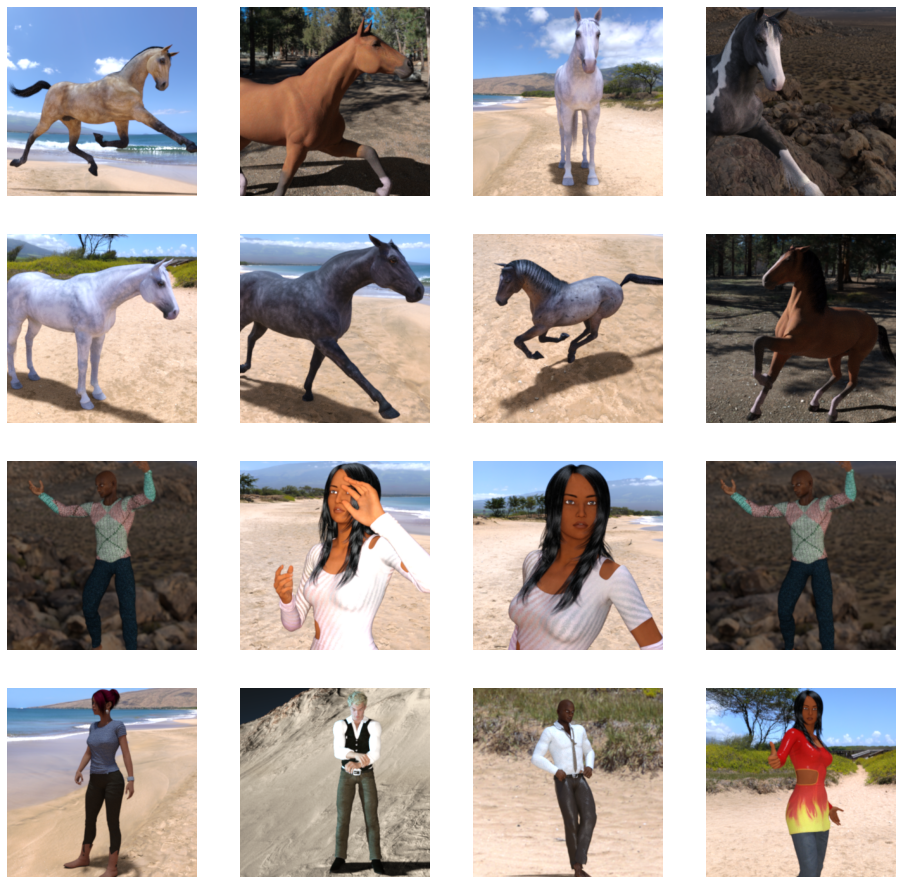

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building The Model

**Define the model architecture that you will train:**

In [ ]:
# Import required libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
#Print the model summary using .summary fn().
#3136 -> 7 * 7 * 64 
#Missed 2 pixels from the pixel in the corner which has no left of upper neighbours.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [ ]:
# Impot RMSprop optimizer
from tensorflow.keras.optimizers import RMSprop

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

## Data Preprocessing

In [ ]:
# Import ImageDateGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Rescalling the training images
# All images will be rescaled by 1/255
train_data_generator = ImageDataGenerator(rescale=1/255)

In [ ]:
# Create Train Generator
# Flow training images in batches of 128 using train_datagen generator
train_generator = train_data_generator.flow_from_directory(
    './horse-or-human/',    #Directory Source Where We Have The ZIP Files For Training Images
    target_size=(300, 300), # All images will be resized to 300x300
    batch_size=128,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.


In [ ]:
#Using callbacks to stop training when it reaches a specific value for some metric
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    #Check the accuracy
    if(logs.get('accuracy') >= 0.99): # Experiment with changing this value
      #Stop if Threshold is met
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

## Model Trainig

In [ ]:
# Instantiate callback class & Train the model
# You can add this later once you created a data valitation 
# validation_data=validation_generator,
# validation_steps=8,
callbacks = myCallback()
history = model.fit(
    train_generator,
    steps_per_epoch=8,
    epochs=15, 
    verbose=1,
    callbacks=[callbacks]
)

Epoch 1/15
8/8 [==============================] - 15s 1s/step - loss: 0.9590 - accuracy: 0.4961
Epoch 2/15
8/8 [==============================] - 6s 688ms/step - loss: 0.7480 - accuracy: 0.6407
Epoch 3/15
8/8 [==============================] - 6s 697ms/step - loss: 0.6618 - accuracy: 0.5595
Epoch 4/15
8/8 [==============================] - 6s 706ms/step - loss: 0.7735 - accuracy: 0.5729
Epoch 5/15
8/8 [==============================] - 7s 733ms/step - loss: 0.5598 - accuracy: 0.7753
Epoch 6/15
8/8 [==============================] - 6s 692ms/step - loss: 0.5471 - accuracy: 0.8298
Epoch 7/15
8/8 [==============================] - 6s 677ms/step - loss: 0.2246 - accuracy: 0.9177
Epoch 8/15
8/8 [==============================] - 6s 753ms/step - loss: 0.4703 - accuracy: 0.8632
Epoch 9/15
8/8 [==============================] - 6s 695ms/step - loss: 0.2405 - accuracy: 0.9210
Epoch 10/15
8/8 [==============================] - 6s 695ms/step - loss: 0.1145 - accuracy: 0.9588
Epoch 11/15
8/8 [====

In [ ]:
#Model History Keys
history.history.keys()

dict_keys(['loss', 'accuracy'])

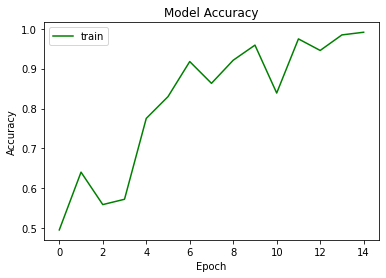

In [ ]:
#Plot Accuracy Curve 
plt.plot(history.history['accuracy'], 'g')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

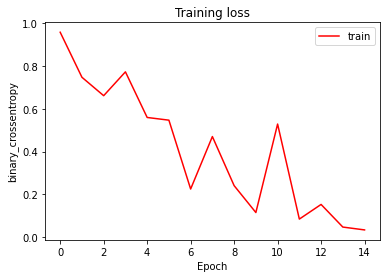

In [ ]:
#Plot Loss Curve 
plt.plot(history.history['loss'], 'r', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('binary_crossentropy')
plt.legend(['train'], loc='upper right')
plt.show()

## Model Prediction
Important Note: Due to some compatibility issues, the following code block will result in an error after you select the images(s) to upload if you are running this notebook as a Colab on the Safari browser. For all other browsers, continue with the next code block and ignore the next one after it.

For Safari users: please comment out or skip the code block below, uncomment the next code block and run it.

In [ ]:
# Model predictions
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
    
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")

## Visualizing Intermediate Representations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


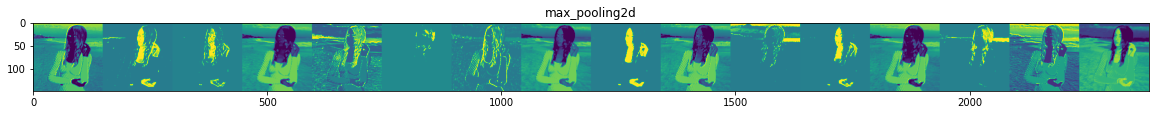

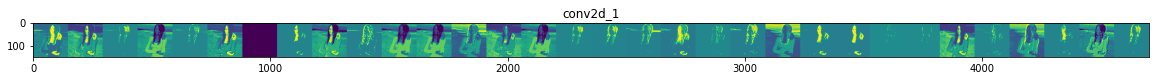

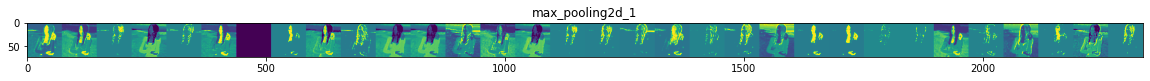

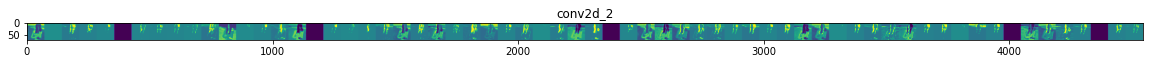

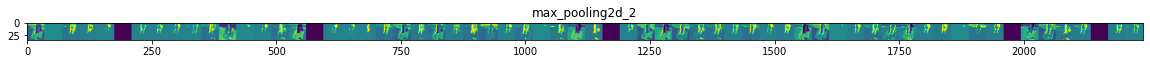

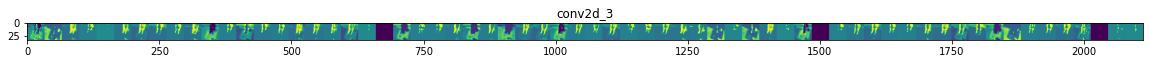

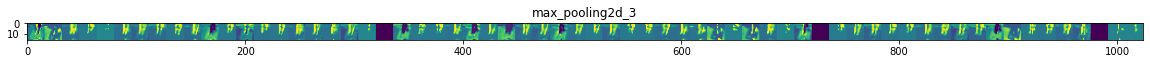

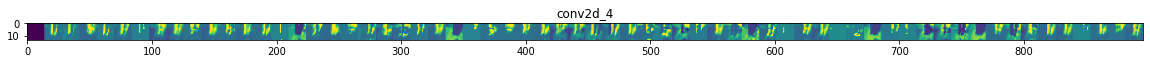

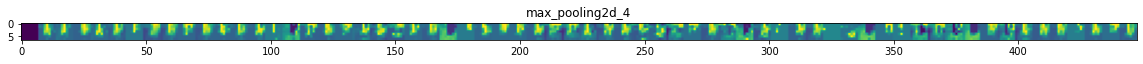

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map

    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
    
      # Tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Clean Up

You will continue with a similar exercise in the next lab but before that, run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)